In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os
import tensorflow as tf
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets, layers, models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

In [14]:
sample_size = 1395
width = 160
height = 160

In [3]:
files = ['A', 'B','C']
file_path = "D:/TITO/Documents/BANGKIT/capstone/protoype2/data6/{}"
data = {}
for f in files:
    data[f]=[]
for col in files:
    os.chdir(file_path.format(col))
    for i in os.listdir(os.getcwd()):
        if i.endswith('.jpg'):
            data[col].append(i)
        if i.endswith('.png'):
            data[col].append(i)

In [4]:
print(len(data['A']))
print(len(data['B']))
print(len(data['C']))

495
450
450


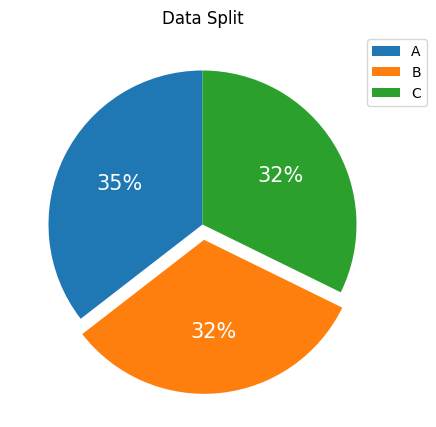

In [5]:
sizes = [len(data['A']), len(data['B']), len(data['C'])]
explode = (0, 0.1, 0) 

plt.figure(figsize=(10, 5), dpi=100)
plt.pie(x=sizes, autopct='%1.0f%%', shadow=False, textprops={'color': "w", "fontsize": 15}, startangle=90, explode=explode)
plt.legend(files, bbox_to_anchor=(0.4, 0, .7, 1))
plt.title("Data Split")
plt.show()

In [16]:
start = time.time()
image_data = []
image_target = []

for title in files:
    os.chdir(file_path.format(title))
    counter = 0
    for i in data[title]:
        img = cv2.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image_data.append(cv2.resize(img,(width, height)))
        image_target.append(title)
        counter += 1
        if counter == sample_size:
            break
    clear_output(wait=True)
    print("Compiled Class",title)
calculate_time = time.time() - start
print("Calculate Time",round(calculate_time,5))

Compiled Class C
Calculate Time 34.50162


In [17]:
image_data = np.array(image_data)
size = image_data.shape[0]
image_data.shape

(1395, 160, 160, 3)

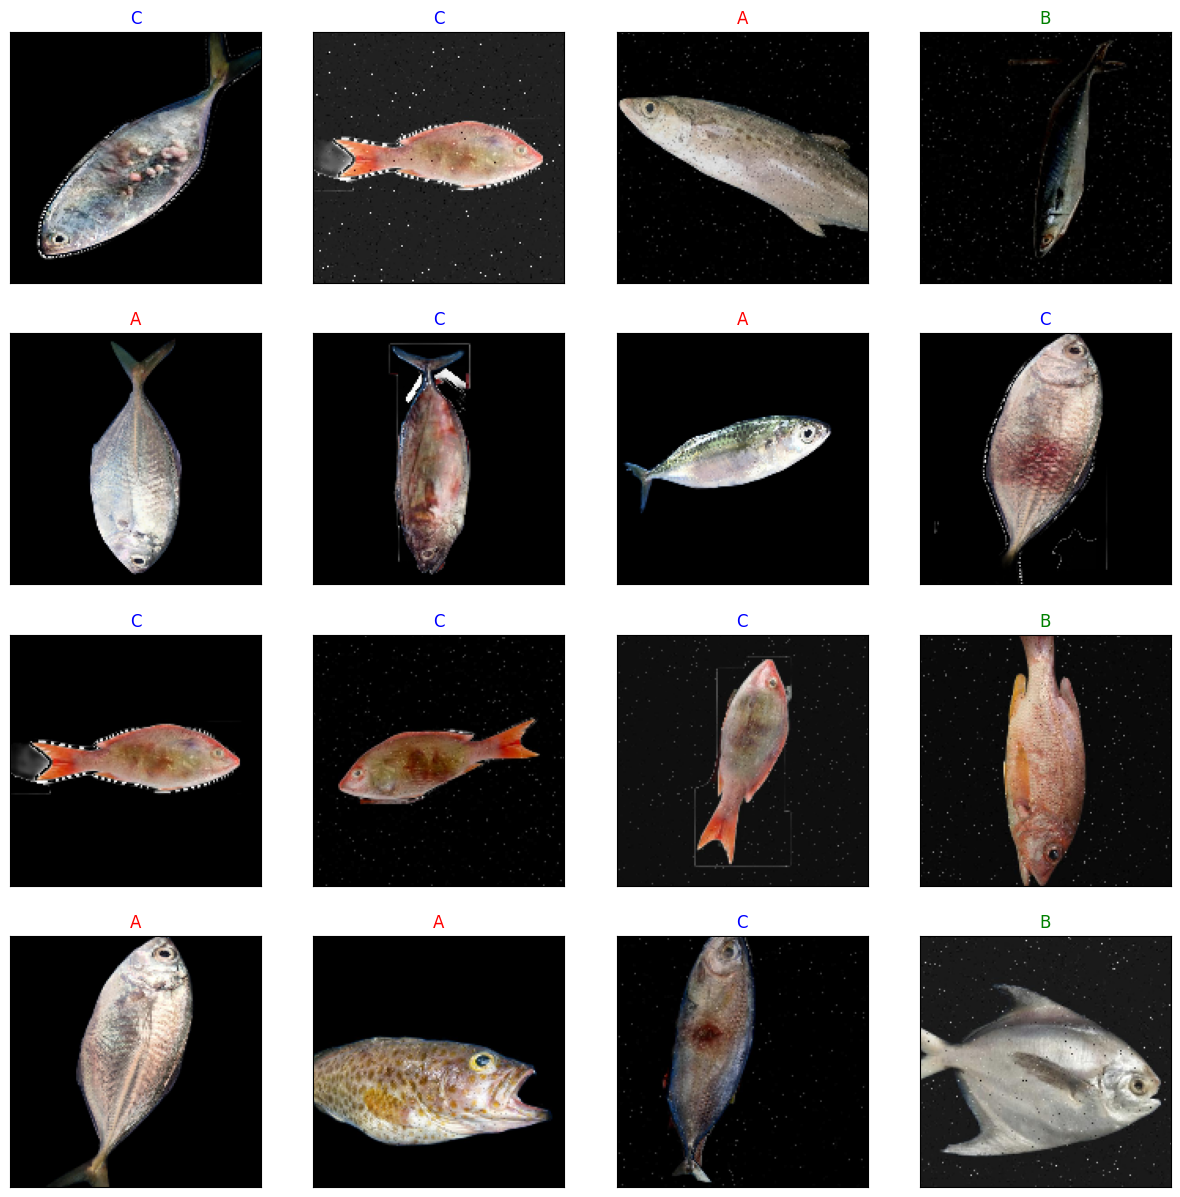

In [18]:
plt.figure(figsize=(15,15))
for i in range(1,17):
    fig = np.random.choice(np.arange(size))
    plt.subplot(4,4,i)
    plt.imshow(image_data[fig])
    if image_target[fig]=='A':
        c='red'
    elif image_target[fig]=='B':
        c='green'
    else:
        c='blue'
    plt.title(image_target[fig], color=c)
    plt.xticks([]), plt.yticks([])
plt.show()

In [19]:
labels = LabelEncoder()
labels.fit(image_target)

LabelEncoder()

In [20]:
X = image_data / 255.0
y = labels.transform(image_target)
train_images, test_images, train_labels, test_labels = train_test_split(X,y, test_size=0.3, random_state=123)


In [15]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(width, height, 3), include_top=False, weights='imagenet')
base_model.trainable = False

In [21]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(3, activation='softmax')
# ])

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 64)                81984     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 2,340,163
Trainable params: 82,179
Non-t

In [23]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                patience=10,
                                                restore_best_weights=True)


In [24]:
# model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics=['accuracy'])

# history = model.fit(train_images, train_labels, epochs=100,
#                     validation_data=(test_images, test_labels), callbacks=[callback])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.CategoricalAccuracy()])

def lr_scheduler(epoch):
    return 0.001 * np.exp(-0.1 * epoch)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Train the model
history = model.fit(train_images, train_labels, epochs=50, validation_data=(test_images, test_labels), callbacks=[lr_callback, callback])

Epoch 1/50
31/31 [==============================] - 53s 328ms/step - loss: 1.0481 - accuracy: 0.5113 - categorical_accuracy: 0.3740 - val_loss: 0.7057 - val_accuracy: 0.7637 - val_categorical_accuracy: 0.4606 - lr: 0.0010
Epoch 2/50
31/31 [==============================] - 4s 137ms/step - loss: 0.6598 - accuracy: 0.7049 - categorical_accuracy: 0.3760 - val_loss: 0.4615 - val_accuracy: 0.8663 - val_categorical_accuracy: 0.4081 - lr: 9.0484e-04
Epoch 3/50
31/31 [==============================] - 4s 136ms/step - loss: 0.4446 - accuracy: 0.8268 - categorical_accuracy: 0.3637 - val_loss: 0.3629 - val_accuracy: 0.8950 - val_categorical_accuracy: 0.3437 - lr: 8.1873e-04
Epoch 4/50
31/31 [==============================] - 4s 132ms/step - loss: 0.3634 - accuracy: 0.8555 - categorical_accuracy: 0.3617 - val_loss: 0.2988 - val_accuracy: 0.8974 - val_categorical_accuracy: 0.3723 - lr: 7.4082e-04
Epoch 5/50
31/31 [==============================] - 4s 131ms/step - loss: 0.3033 - accuracy: 0.9006 - c

14/14 - 1s - loss: 0.1766 - accuracy: 0.9379 - categorical_accuracy: 0.3747 - 1s/epoch - 97ms/step


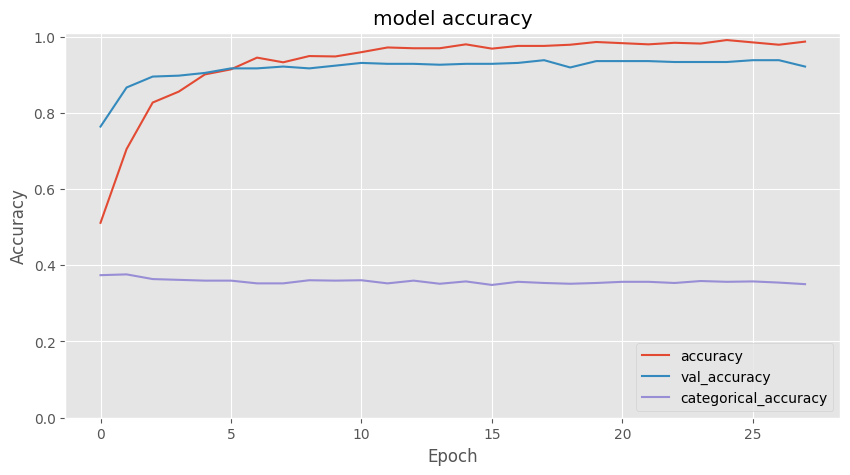

In [25]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.title('model accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.01])
plt.legend(loc='lower right')

test_acc = model.evaluate(test_images,  test_labels, verbose=2)

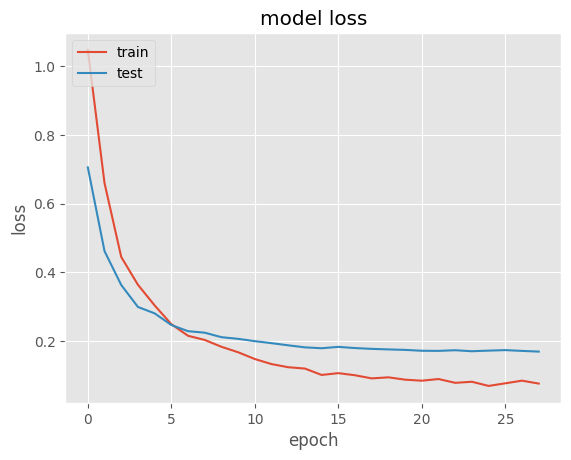

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
base_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 147

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False
model.summary()

Number of layers in the base model:  154
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 64)                81984     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params:

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2,422,339
Trainable params: 577,155
Non-tr

In [28]:
# model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics=['accuracy'])

# history = model.fit(train_images, train_labels, epochs=100,
#                     validation_data=(test_images, test_labels), callbacks=[callback])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001), loss='sparse_categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.CategoricalAccuracy()])

def lr_scheduler(epoch):
    return 0.001 * np.exp(-0.1 * epoch)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Train the model
history = model.fit(train_images, train_labels, epochs=50, validation_data=(test_images, test_labels), callbacks=[lr_callback, callback])

Epoch 1/50
31/31 [==============================] - 46s 1s/step - loss: 0.6101 - accuracy: 0.7848 - categorical_accuracy: 0.3525 - val_loss: 4.0433 - val_accuracy: 0.4439 - val_categorical_accuracy: 0.8974 - lr: 0.0010
Epoch 2/50
31/31 [==============================] - 4s 134ms/step - loss: 0.2638 - accuracy: 0.9170 - categorical_accuracy: 0.3566 - val_loss: 2.6739 - val_accuracy: 0.5585 - val_categorical_accuracy: 0.7780 - lr: 9.0484e-04
Epoch 3/50
31/31 [==============================] - 4s 139ms/step - loss: 0.1874 - accuracy: 0.9262 - categorical_accuracy: 0.3596 - val_loss: 2.7356 - val_accuracy: 0.6110 - val_categorical_accuracy: 0.7351 - lr: 8.1873e-04
Epoch 4/50
31/31 [==============================] - 4s 137ms/step - loss: 0.1485 - accuracy: 0.9416 - categorical_accuracy: 0.3514 - val_loss: 4.3844 - val_accuracy: 0.5060 - val_categorical_accuracy: 0.8353 - lr: 7.4082e-04
Epoch 5/50
31/31 [==============================] - 4s 129ms/step - loss: 0.0987 - accuracy: 0.9621 - cate

14/14 - 1s - loss: 0.4310 - accuracy: 0.9403 - categorical_accuracy: 0.4081 - 1s/epoch - 88ms/step


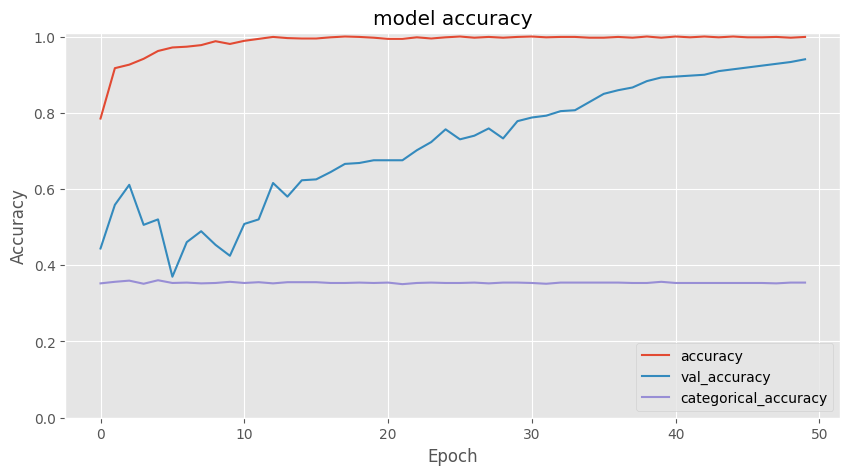

In [29]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.title('model accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.01])
plt.legend(loc='lower right')

test_acc = model.evaluate(test_images,  test_labels, verbose=2)

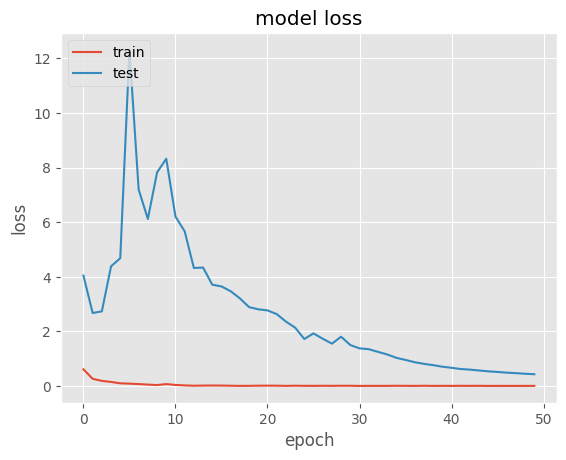

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [48]:
result=model.evaluate(train_images, train_labels)

31/31 [==============================] - 14s 445ms/step - loss: 0.0020 - accuracy: 0.9990 - categorical_accuracy: 0.3545


In [49]:
result=model.evaluate(test_images, test_labels)

14/14 [==============================] - 6s 425ms/step - loss: 0.3380 - accuracy: 0.9499 - categorical_accuracy: 0.3938


In [34]:
for i in range(len(model.metrics_names)):
    print(model.metrics_names[i],":",result[i])

loss : 0.4310450851917267
accuracy : 0.940334141254425
categorical_accuracy : 0.40811455249786377


In [27]:
# model.summary()

14/14 [==============================] - 6s 442ms/step


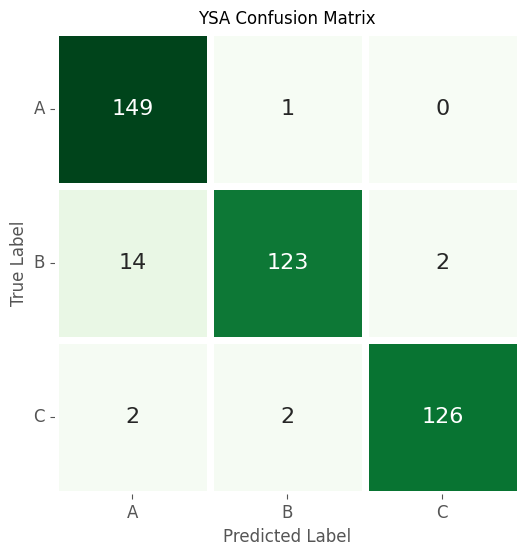

In [50]:
y_pred = model.predict(test_images)

def toClass(pred):

    class_ = np.zeros(len(pred))
    for i in range(len(pred)):
        index = pred[i].argmax()
        class_[i] = index

    return class_

cm = confusion_matrix(test_labels,toClass(y_pred))

df1 = pd.DataFrame(columns=["A","B", "C"], index= ["A","B", "C"], data= cm )

f,ax = plt.subplots(figsize=(6,6))

sns.heatmap(df1, annot=True,cmap="Greens", fmt= '.0f',ax=ax,linewidths = 5, cbar = False,annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("True Label")
plt.title("YSA Confusion Matrix", size = 12)
plt.show()

In [51]:
import sklearn.metrics as metrics

precision = metrics.precision_score(test_labels, toClass(y_pred), average='macro')
print('Precision: %f' % precision)

Precision: 0.954532


In [52]:
recall = metrics.recall_score(test_labels, toClass(y_pred), average='macro')
print('Recall: %f' % recall)

Recall: 0.949152


In [53]:
f1 = metrics.f1_score(test_labels, toClass(y_pred), average='macro')
print('F1 score: %f' % f1)

F1 score: 0.950359


In [47]:
history = model.fit(train_images, train_labels, epochs=100, validation_data=(test_images, test_labels), callbacks=[lr_callback, callback])

Epoch 1/100
31/31 [==============================] - 25s 813ms/step - loss: 0.0452 - accuracy: 0.9836 - categorical_accuracy: 0.3494 - val_loss: 5.1106 - val_accuracy: 0.6348 - val_categorical_accuracy: 0.7136 - lr: 0.0010
Epoch 2/100
31/31 [==============================] - 23s 744ms/step - loss: 0.0229 - accuracy: 0.9887 - categorical_accuracy: 0.3545 - val_loss: 5.1887 - val_accuracy: 0.6062 - val_categorical_accuracy: 0.7470 - lr: 9.0484e-04
Epoch 3/100
31/31 [==============================] - 23s 759ms/step - loss: 0.0866 - accuracy: 0.9754 - categorical_accuracy: 0.3586 - val_loss: 4.8799 - val_accuracy: 0.6611 - val_categorical_accuracy: 0.6945 - lr: 8.1873e-04
Epoch 4/100
31/31 [==============================] - 23s 745ms/step - loss: 0.1316 - accuracy: 0.9590 - categorical_accuracy: 0.3412 - val_loss: 8.0078 - val_accuracy: 0.5585 - val_categorical_accuracy: 0.7971 - lr: 7.4082e-04
Epoch 5/100
31/31 [==============================] - 23s 746ms/step - loss: 0.1101 - accuracy: 0

In [54]:
def Prediction2(test_image):

    global width, height, files, labels

    img = image.img_to_array(test_image)
    img = np.expand_dims(img, axis=0)
    img = img/255.0
    
    class_list = ['A', 'B', 'C'] 
    
    pred = model.predict(img)
    predicted_class = class_list[np.argmax(pred[0])]
    return predicted_class

1/1 [==============================] - 0s 29ms/step


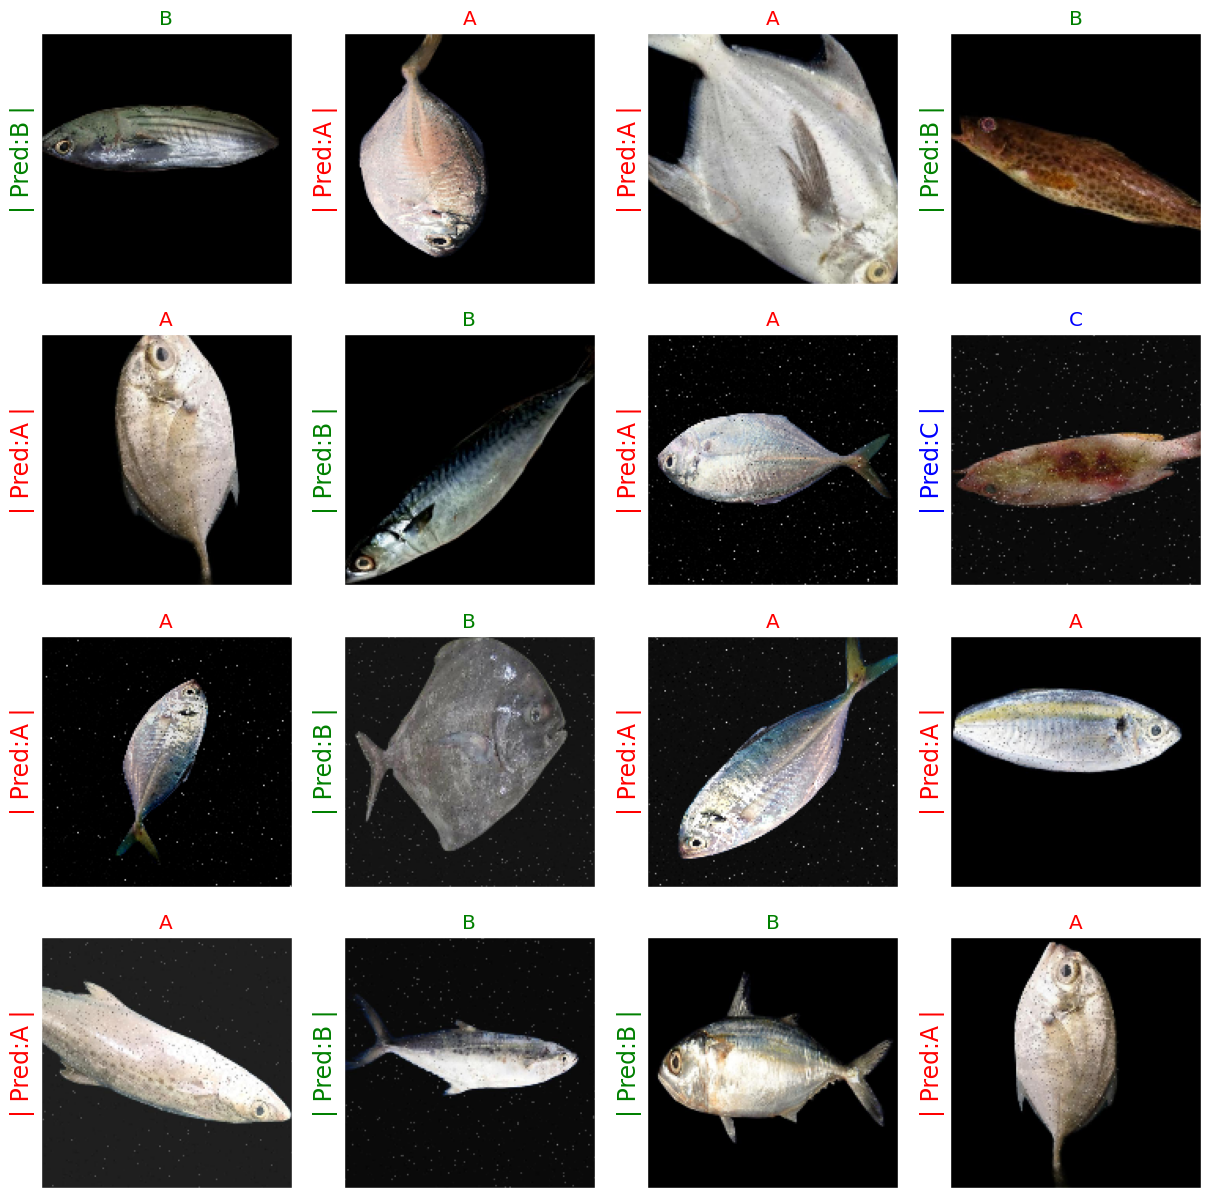

In [55]:
plt.figure(figsize=(15,15))
for i in range(1,17):
    fig = np.random.choice(np.arange(size))
    plt.subplot(4,4,i)
    plt.imshow(image_data[fig])
    if image_target[fig]=='A':
        c='red'
    elif image_target[fig]=='B':
        c='green'
    else:
        c='blue'
    plt.title(image_target[fig], color=c)
    plt.ylabel("| Pred:{} |".format(Prediction2(image_data[fig])),fontsize=17, color=c)
    plt.xticks([]), plt.yticks([])
plt.show()

IMG20230517080311_jpg.rf.3451cb7a64a92fbac41b5e84d7e14872.jpg
1/1 [==============================] - 0s 33ms/step
Prediction range:
Minimum value: 0.0
Maximum value: 1.0
Grade: A
Good
IMG20230517080311_jpg.rf.4581690921b38e87fe05df867066bdaf.jpg
1/1 [==============================] - 0s 35ms/step
Prediction range:
Minimum value: 3.4838593e-33
Maximum value: 1.0
Grade: A
Good
IMG20230517080311_jpg.rf.ac321ed0d06597f17e5b50e9a7c202c4.jpg
1/1 [==============================] - 0s 28ms/step
Prediction range:
Minimum value: 0.0
Maximum value: 1.0
Grade: A
Good
IMG20230518073006_jpg.rf.282e6290c6e36f85e91ff63973db7bed.jpg
1/1 [==============================] - 0s 37ms/step
Prediction range:
Minimum value: 6.167794e-27
Maximum value: 1.0
Grade: A
Good
IMG20230518073006_jpg.rf.369195516dd07c6c088a7f395f54d233.jpg
1/1 [==============================] - 0s 27ms/step
Prediction range:
Minimum value: 1.859677e-31
Maximum value: 1.0
Grade: A
Good
IMG20230518073006_jpg.rf.44209138c206e7054bf044759d8

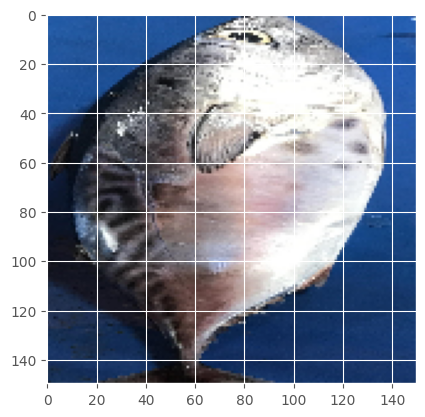

In [57]:
# user_path = r"C:\laragon\www\Project\Bloomy\img\output"
user_path = r"D:\\TITO\\Documents\\BANGKIT\\capstone\\protoype2\\data\\A"

image_files = os.listdir(user_path)
for idx in range(0, 149):
    index = idx
    image_file = os.path.join(user_path, image_files[index])

    print(image_files[index])
    img = image.load_img(image_file, target_size=(150, 150))
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0 

    classes = model.predict(x, batch_size=1)
    nilai_min = np.min(classes)
    nilai_max = np.max(classes)

    print("Prediction range:")
    print("Minimum value:", nilai_min)
    print("Maximum value:", nilai_max)

    class_list = ['A', 'B', 'C'] 

    predicted_class = class_list[np.argmax(classes[0])]
    print('Grade:', predicted_class)

    if predicted_class == 'A':
        print('Good')
    

    elif predicted_class == 'B':
        print('Medium')


    elif predicted_class == 'C':
        print('Bad')

In [56]:
# file_location = 'D:\\Users\\Andra\Documents\\Bloomy\\prototype\\fish_grading.h5'
# file_location = 'C:\laragon\www\Project\Bloomy\model\\fishgrading.h5'
file_location = 'D:\\TITO\\Documents\\BANGKIT\\capstone\\protoype2\\bloomy-fishgrading/fishgrading_model_new_2.h5'

model.save(file_location)